In [6]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler

# Các model scikit learn cho bài toán phân loại
from sklearn.svm import SVC # Support vector machine
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
from tqdm import tqdm

import os, sys
sys.path.append(os.path.abspath(".."))

seed = 42
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from tqdm import tqdm
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted

class ProgressWrapper:
    """
    Lớp bao bọc để thêm thanh tiến trình `tqdm` cho quá trình huấn luyện của bất kỳ mô hình nào từ Scikit-learn.
    """
    def __init__(self, model):
        self.model = clone(model)

    def fit(self, X, y, **fit_params):
        # Đếm tổng số cây (estimators) được xây dựng trong RandomForestClassifier
        n_estimators = getattr(self.model, 'n_estimators', 1)

        with tqdm(total=n_estimators, desc="Training", unit="tree") as pbar:
            original_fit = self.model.fit

            def fit_and_update(*args, **kwargs):
                for i in range(n_estimators):
                    original_fit(*args, **kwargs)
                    pbar.update(1)

            self.model.fit = fit_and_update
            try:
                self.model.fit(X, y, **fit_params)
            finally:
                self.model.fit = original_fit
                pbar.close()

        return self

    def predict(self, X):
        check_is_fitted(self.model)
        return self.model.predict(X)

    def predict_proba(self, X : np.ndarray):
        check_is_fitted(self.model)
        return self.model.predict_proba(X)

    def score(self, X, y):
        check_is_fitted(self.model)
        return self.model.score(X, y)

    def __getattr__(self, name):
        return getattr(self.model, name)

In [8]:
train_df = pd.read_csv("../../data/key_points_rotated.csv")

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 100 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               436 non-null    object 
 1   nose_x              436 non-null    float64
 2   nose_y              436 non-null    float64
 3   nose_z              436 non-null    float64
 4   left_eye_inner_x    436 non-null    float64
 5   left_eye_inner_y    436 non-null    float64
 6   left_eye_inner_z    436 non-null    float64
 7   left_eye_x          436 non-null    float64
 8   left_eye_y          436 non-null    float64
 9   left_eye_z          436 non-null    float64
 10  left_eye_outer_x    436 non-null    float64
 11  left_eye_outer_y    436 non-null    float64
 12  left_eye_outer_z    436 non-null    float64
 13  right_eye_inner_x   436 non-null    float64
 14  right_eye_inner_y   436 non-null    float64
 15  right_eye_inner_z   436 non-null    float64
 16  right_e

In [10]:
train_df.columns

Index(['label', 'nose_x', 'nose_y', 'nose_z', 'left_eye_inner_x',
       'left_eye_inner_y', 'left_eye_inner_z', 'left_eye_x', 'left_eye_y',
       'left_eye_z', 'left_eye_outer_x', 'left_eye_outer_y',
       'left_eye_outer_z', 'right_eye_inner_x', 'right_eye_inner_y',
       'right_eye_inner_z', 'right_eye_x', 'right_eye_y', 'right_eye_z',
       'right_eye_outer_x', 'right_eye_outer_y', 'right_eye_outer_z',
       'left_ear_x', 'left_ear_y', 'left_ear_z', 'right_ear_x', 'right_ear_y',
       'right_ear_z', 'mouth_left_x', 'mouth_left_y', 'mouth_left_z',
       'mouth_right_x', 'mouth_right_y', 'mouth_right_z', 'left_shoulder_x',
       'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y',
       'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z',
       'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x',
       'right_wrist_y', 'right_wrist_z', 'left_pinky_x', 'left_pinky_y

In [11]:
train_df.head()

,label,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,left_eye_z,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,1_lie_on,0.177284,-0.254931,-0.260886,0.179060,-0.275685,-0.239805,0.183819,-0.275859,-0.239737,...,-0.058082,0.070646,0.338102,-0.077273,0.080555,0.406826,-0.168110,0.052259,0.435796,-0.194409
1,1_lie_on,0.008197,-0.323546,-0.256766,0.022694,-0.349245,-0.234660,0.031205,-0.346371,-0.234611,...,0.082603,-0.019137,0.429928,0.054545,0.032849,0.442523,-0.035663,-0.047199,0.495067,-0.089421
2,1_lie_on,0.011048,-0.239566,-0.555332,0.032762,-0.272934,-0.536229,0.044995,-0.272415,-0.536120,...,0.324744,-0.003249,0.602408,0.128405,0.071119,0.496722,0.267827,-0.002625,0.713785,-0.003046
3,1_lie_on,-0.055705,-0.154004,-0.203446,-0.063247,-0.173053,-0.149985,-0.053848,-0.174954,-0.150037,...,-0.346393,-0.045419,0.355155,-0.346069,-0.021062,0.429321,-0.501384,-0.014643,0.395276,-0.547637
4,1_lie_on,-0.023451,-0.169208,-0.388429,0.010504,-0.169281,-0.331276,0.028045,-0.162457,-0.330836,...,-0.012170,0.001742,0.411796,-0.126968,0.203705,0.460730,-0.189556,-0.003900,0.496045,-0.307282


<Axes: xlabel='label', ylabel='count'>

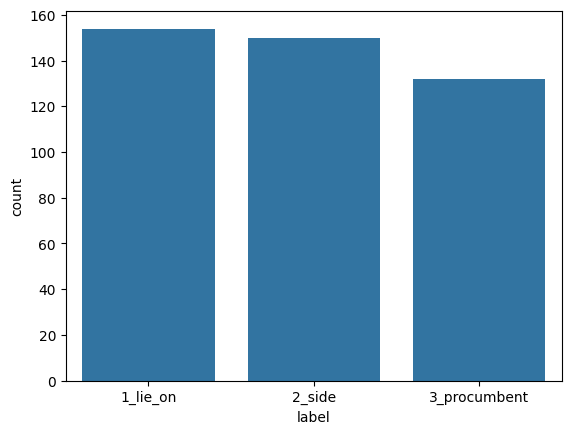

In [12]:
sns.countplot(x="label", data=train_df)

In [13]:
# Chuyển dữ liệu của label về dạng số
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])

In [14]:
# Extract features
X_train = train_df.drop(columns="label")
y_train = train_df["label"]

In [15]:
X_train.head()

,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,left_eye_z,left_eye_outer_x,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,0.177284,-0.254931,-0.260886,0.179060,-0.275685,-0.239805,0.183819,-0.275859,-0.239737,0.188639,...,-0.058082,0.070646,0.338102,-0.077273,0.080555,0.406826,-0.168110,0.052259,0.435796,-0.194409
1,0.008197,-0.323546,-0.256766,0.022694,-0.349245,-0.234660,0.031205,-0.346371,-0.234611,0.038856,...,0.082603,-0.019137,0.429928,0.054545,0.032849,0.442523,-0.035663,-0.047199,0.495067,-0.089421
2,0.011048,-0.239566,-0.555332,0.032762,-0.272934,-0.536229,0.044995,-0.272415,-0.536120,0.056272,...,0.324744,-0.003249,0.602408,0.128405,0.071119,0.496722,0.267827,-0.002625,0.713785,-0.003046
3,-0.055705,-0.154004,-0.203446,-0.063247,-0.173053,-0.149985,-0.053848,-0.174954,-0.150037,-0.044969,...,-0.346393,-0.045419,0.355155,-0.346069,-0.021062,0.429321,-0.501384,-0.014643,0.395276,-0.547637
4,-0.023451,-0.169208,-0.388429,0.010504,-0.169281,-0.331276,0.028045,-0.162457,-0.330836,0.048718,...,-0.012170,0.001742,0.411796,-0.126968,0.203705,0.460730,-0.189556,-0.003900,0.496045,-0.307282


In [16]:
y_train

0      0
1      0
2      0
3      0
4      0
      ..
431    2
432    2
433    2
434    2
435    2
Name: label, Length: 436, dtype: int32

In [17]:
# Chuẩn hoá dữ liệu trên tập huấn luyện bằng z-scores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [18]:
# X lúc này là một DataFrame mới với các cột mới được đánh số từ 0 đến n-1, trong đó n là số lượng cột trong dữ liệu ban đầu
X_train

array([[ 2.00170954,  0.34272308, -0.08767959, ...,  0.35560663,
         0.10053083, -0.5800713 ],
       [ 0.11642512, -0.24455622, -0.07128793, ..., -0.17601759,
         0.47998336, -0.37885293],
       [ 0.14820465,  0.47423837, -1.25922009, ...,  0.06223709,
         1.88021557, -0.21330631],
       ...,
       [-0.26404664,  0.15813388, -0.43793722, ...,  0.77052878,
        -0.34604644,  1.46752188],
       [-0.29122628,  0.52323442,  1.62850366, ...,  0.52404547,
        -0.57246353, -0.01830796],
       [ 1.13377471,  1.04636163,  2.72021579, ...,  1.21098604,
        -0.59713738, -0.57894028]])

In [19]:
import warnings
warnings.filterwarnings("ignore")

k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

In [20]:
def evaluate_model(name, model, results):
    # Đánh giá Model
    accuracy = cross_val_score(
        model, X_train, y_train, cv=k_fold, scoring="accuracy", n_jobs=-1, verbose=1
    ).mean()

    f1_score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring="f1_macro").mean()
    results.append((name, accuracy, f1_score))

In [21]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    ("SVC", SVC(probability=True, random_state=seed)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("RF", RandomForestClassifier(random_state=seed)),
    ("XGB", XGBClassifier(random_state=seed)),
]

models = {}
results_before_tunning = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model
    evaluate_model(name, model, results_before_tunning)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


In [22]:
def print_results(results):
    results.sort(key=lambda el: el[2], reverse=True)

    return pd.DataFrame(
        results,
        columns=[
            "Model",
            "Accuracy score",
            "F1 score",
        ],
    )

print_results(results_before_tunning)

,Model,Accuracy score,F1 score
0,SVC,0.899112,0.897377
1,RF,0.878448,0.875832
2,XGB,0.876176,0.872164
3,LR,0.866902,0.861879
4,KNN,0.823276,0.817598
5,DTC,0.791327,0.786314


<Axes: xlabel='F1 score', ylabel='Model'>

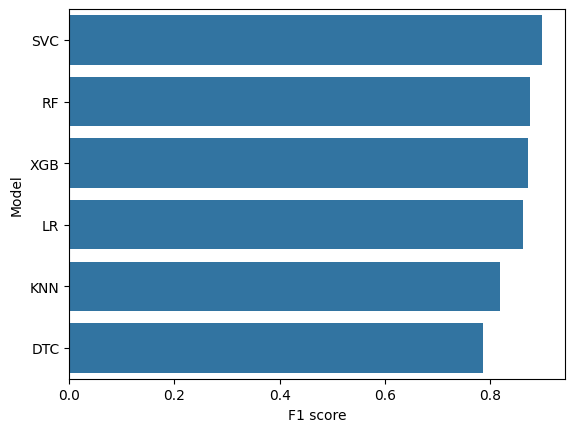

In [23]:
sns.barplot(x="F1 score", y="Model", data=print_results(results_before_tunning))

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

In [25]:
y_pred = models['SVC'].predict(X_train)
cm_full_train = confusion_matrix(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
cm_full_train, accuracy

(array([[151,   3,   0],
        [  5, 144,   1],
        [ 10,   2, 120]], dtype=int64),
 0.9518348623853211)

In [26]:
svc_best_model = SVC(probability=True, random_state=seed)

svc_best_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [27]:
accuracy = cross_val_score(svc_best_model, X_train, y_train, cv=k_fold, scoring="accuracy").mean()
y_pred = cross_val_predict(svc_best_model, X_train, y_train, cv=k_fold)
cm_cross_val = confusion_matrix(y_train, y_pred)
accuracy, cm_cross_val

(0.8991118077324975,
 array([[147,   4,   3],
        [ 10, 134,   6],
        [ 15,   6, 111]], dtype=int64))

<Axes: >

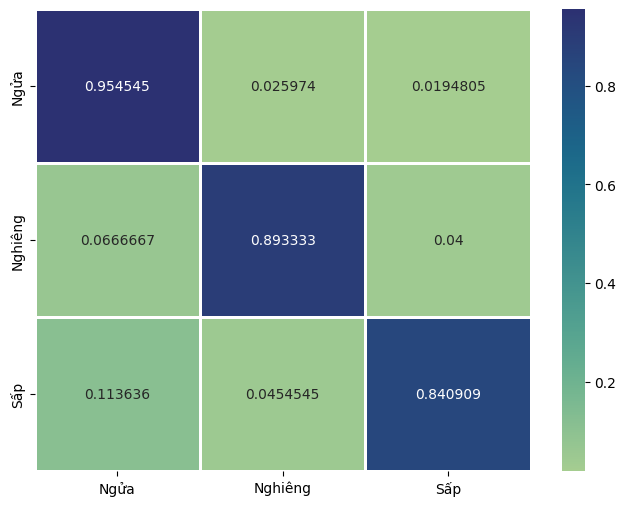

In [28]:
label_counts = np.sum(cm_cross_val, axis=1)
cm_cross_val = cm_cross_val / label_counts[:, None]
confusion_matrix_df = pd.DataFrame(cm_cross_val, index=["Ngửa", "Nghiêng", "Sấp"], columns=["Ngửa", "Nghiêng", "Sấp"])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, linewidths=1, annot=True, ax=ax, fmt="g", cmap="crest")